In [1]:
import torch
torch.manual_seed(42)
import torch.nn as nn
import torchvision.models as models
from libauc.optimizers import SGD, Adam,PESG
from libauc.losses import CrossEntropyLoss, AUCMLoss
from torch.utils.data import DataLoader, random_split
import os
os.environ['medmnist_data_dir'] = 'D:\\Download\\CSCE633\\project\\data'
import medmnist
from medmnist.dataset import NoduleMNIST3D
# BreastMNIST, PneumoniaMNIST, ChestMNIST, NoduleMNIST3D, AdrenalMNIST3D, VesselMNIST3D, SynapseMNIST3D
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
from medmnist import INFO, Evaluator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchio as tio
import warnings
warnings.filterwarnings('ignore')

d:\adahx\anaconda3\envs\new_env_project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


parameters

In [2]:
data_flag = 'nodulemnist3d'

NUM_EPOCHS = 50
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
print("Task on this dataset is", task)
print("Number of channels", n_channels)
print("Number of classes", n_classes)

Task on this dataset is binary-class
Number of channels 1
Number of classes 2


preprosessing

In [4]:
# data augmentation
data_transform = tio.Compose([
    tio.Resample((1, 1, 1)),
    tio.CropOrPad((28, 28, 28)),
    tio.ToCanonical(),
    # add more transforms here
    tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10), translation=(-0.1, 0.1), center='image', isotropic=True, default_pad_value='mean', p=0.5),
    tio.RandomElasticDeformation(max_displacement=(5, 5, 5), num_control_points=(5, 5, 5), locked_borders=1, p=0.5),
    tio.RandomFlip(axes=(0, 1, 2), p=0.5),
    tio.RandomNoise(std=(0.01, 0.05), p=0.5),
])



In [5]:
data_dir = 'D:\\Download\\CSCE633\\project\\data'

load data

In [6]:
# load data
train_data = DataClass(root=data_dir, split = 'train', transform=data_transform)
test_data = DataClass(root=data_dir, split = 'test', transform=data_transform)
val_data = DataClass(root=data_dir, split = 'val', transform=data_transform)


In [15]:
# add class weights for imbalanced dataset
binary_labels = [train_data[i][1] for i in range(len(train_data))]

# Count the number of positive (1) and negative (0) samples
positive_count = np.sum(binary_labels)
negative_count = len(binary_labels) - positive_count

print(f"Positive samples: {positive_count}")
print(f"Negative samples: {negative_count}")

Positive samples: 295
Negative samples: 863


In [16]:
positive_samples = 295
negative_samples = 863
total_samples = positive_samples + negative_samples

# Calculate class weights
class_weights = [total_samples / negative_samples, total_samples / positive_samples]

# Convert class weights to a tensor
class_weights_tensor = torch.FloatTensor(class_weights)

print(class_weights_tensor)

tensor([1.3418, 3.9254])


In [7]:
# dataloader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_data, batch_size=2*BATCH_SIZE, shuffle=False)

In [8]:
print(train_data)
print('=====================')
print(test_data)

Dataset NoduleMNIST3D (nodulemnist3d)
    Number of datapoints: 1158
    Root location: D:\Download\CSCE633\project\data
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'benign', '1': 'malignant'}
    Number of samples: {'train': 1158, 'val': 165, 'test': 310}
    Description: The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.
    License: CC BY 4.0
Dataset NoduleMNIST3D (nodulemnist3d)
    Number of datapoints: 310
 

In [9]:
res = [0]*11
for i in range(len(train_data.labels)):
    res[train_data.labels[i][0]] += 1
print(res)
img1 = train_data.montage(length = 10)
img1[10].show()

[863, 295, 0, 0, 0, 0, 0, 0, 0, 0, 0]


evaluation function will be used to evaluate the model

In [10]:
def evaluate(dataloader):
    model.eval()
    correct = 0
    total = 0
    auc_score = 0.0
    skipped_batches = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.float().to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Calculate AUC score (assuming binary classification)
            targets = targets.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()[:, 1]  # Get scores for the positive class
            
            # Check if there is more than one class in targets
            if len(np.unique(targets)) > 1:
                auc_score += roc_auc_score(targets, outputs)
            else:
                skipped_batches += 1

    acc = correct / total
    auc_score /= (len(dataloader) - skipped_batches)

    return auc_score, acc


# DAM

## Resnet18-3D

In [11]:
# from libauc.models import resnet18 as ResNet18
from resnet2p1d import generate_model
model_depth = 18

# Create the ResNet2p1D-18 model
model = generate_model(model_depth, n_input_channels=n_channels, n_classes=n_classes)


In [12]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
class_weights_tensor = class_weights_tensor.to(device)

In [20]:
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

Training with Adam optimizer...


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.755062726012142, Train ACC: 22.018998272884282
Test AUC: 0.7751878633020873, Test ACC: 23.16774193548387
==> Best test AUC and ACC score updated: 0.7752, 23.1677


100%|██████████| 37/37 [00:17<00:00,  2.10it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.8040460257132251, Train ACC: 18.238341968911918
Test AUC: 0.8059311509850303, Test ACC: 18.322580645161292
==> Best test AUC and ACC score updated: 0.8059, 18.3226


100%|██████████| 37/37 [00:17<00:00,  2.13it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.8337716023141429, Train ACC: 20.322970639032814
Test AUC: 0.7926672397685329, Test ACC: 20.774193548387096


100%|██████████| 37/37 [00:17<00:00,  2.11it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.8357848952767901, Train ACC: 14.431778929188255
Test AUC: 0.8328126574893817, Test ACC: 14.058064516129033
==> Best test AUC and ACC score updated: 0.8328, 14.0581


100%|██████████| 37/37 [00:18<00:00,  2.05it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.8338198620449763, Train ACC: 20.386873920552677
Test AUC: 0.8623387835025766, Test ACC: 21.058064516129033
==> Best test AUC and ACC score updated: 0.8623, 21.0581


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.8652670941844282, Train ACC: 20.57685664939551
Test AUC: 0.875085337714648, Test ACC: 20.73548387096774
==> Best test AUC and ACC score updated: 0.8751, 20.7355


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.8646695818434947, Train ACC: 18.91882556131261
Test AUC: 0.8568907692722348, Test ACC: 19.690322580645162


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.8693332961428518, Train ACC: 19.671848013816927
Test AUC: 0.8883087502376295, Test ACC: 20.141935483870967
==> Best test AUC and ACC score updated: 0.8883, 20.1419


100%|██████████| 37/37 [00:17<00:00,  2.16it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.8930330732139203, Train ACC: 16.79965457685665
Test AUC: 0.8921518830786074, Test ACC: 16.741935483870968
==> Best test AUC and ACC score updated: 0.8922, 16.7419


100%|██████████| 37/37 [00:17<00:00,  2.12it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.8829713732378285, Train ACC: 19.360967184801382
Test AUC: 0.8883828073267729, Test ACC: 19.767741935483873


100%|██████████| 37/37 [00:17<00:00,  2.06it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.8867624984515712, Train ACC: 17.511226252158895
Test AUC: 0.8866306681823923, Test ACC: 17.729032258064517


100%|██████████| 37/37 [00:17<00:00,  2.06it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.8983577514300021, Train ACC: 19.4559585492228
Test AUC: 0.8939699668147945, Test ACC: 19.741935483870968
==> Best test AUC and ACC score updated: 0.8940, 19.7419


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.9084217829645542, Train ACC: 18.76511226252159
Test AUC: 0.8907696661575972, Test ACC: 19.451612903225808


100%|██████████| 37/37 [00:17<00:00,  2.09it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.904073199169072, Train ACC: 19.506044905008636
Test AUC: 0.9120012949215536, Test ACC: 19.980645161290322
==> Best test AUC and ACC score updated: 0.9120, 19.9806


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.9005062657545789, Train ACC: 19.050086355785837
Test AUC: 0.8777059434818055, Test ACC: 19.38064516129032


100%|██████████| 37/37 [00:16<00:00,  2.21it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.9289594640681598, Train ACC: 19.683937823834196
Test AUC: 0.9057410365815539, Test ACC: 20.12258064516129


100%|██████████| 37/37 [00:17<00:00,  2.16it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.8950452450516566, Train ACC: 20.250431778929187
Test AUC: 0.8763842276019, Test ACC: 21.238709677419354


100%|██████████| 37/37 [00:18<00:00,  2.06it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.9102407401282965, Train ACC: 17.91364421416235
Test AUC: 0.8856423433686365, Test ACC: 18.4


100%|██████████| 37/37 [00:19<00:00,  1.94it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.8942800263995915, Train ACC: 21.3713298791019
Test AUC: 0.8567749336391579, Test ACC: 22.129032258064516


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.9253879325805862, Train ACC: 19.488773747841105
Test AUC: 0.9206538456753975, Test ACC: 19.690322580645162
==> Best test AUC and ACC score updated: 0.9207, 19.6903


100%|██████████| 37/37 [00:17<00:00,  2.16it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.9175770223571331, Train ACC: 19.946459412780655
Test AUC: 0.8991833214678044, Test ACC: 20.954838709677418


100%|██████████| 37/37 [00:18<00:00,  2.05it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.9209490176600372, Train ACC: 20.07426597582038
Test AUC: 0.8721853027240958, Test ACC: 20.490322580645163


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.9270964230446497, Train ACC: 18.65284974093264
Test AUC: 0.9067389841958807, Test ACC: 19.741935483870968


100%|██████████| 37/37 [00:16<00:00,  2.19it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.9145734145503793, Train ACC: 17.810017271157168
Test AUC: 0.8763914737082841, Test ACC: 18.24516129032258


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.935741697061777, Train ACC: 18.09671848013817
Test AUC: 0.8921151170827896, Test ACC: 18.741935483870968


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.9334177004578152, Train ACC: 19.784110535405873
Test AUC: 0.8894543563078047, Test ACC: 20.26451612903226


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.9472687333685617, Train ACC: 20.58203799654577
Test AUC: 0.862346725751898, Test ACC: 21.038709677419355


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.9275342650573051, Train ACC: 19.25215889464594
Test AUC: 0.9058798210091312, Test ACC: 19.974193548387095


100%|██████████| 37/37 [00:16<00:00,  2.19it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.9293318462616871, Train ACC: 18.466321243523318
Test AUC: 0.9003038871250079, Test ACC: 18.858064516129033


100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.9195428281297847, Train ACC: 18.316062176165804
Test AUC: 0.9037070364979847, Test ACC: 18.309677419354838


100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.9198801473257995, Train ACC: 19.59585492227979
Test AUC: 0.905555094251215, Test ACC: 19.83225806451613


100%|██████████| 37/37 [00:16<00:00,  2.20it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.9411846534672621, Train ACC: 19.020725388601036
Test AUC: 0.8964711394129496, Test ACC: 19.141935483870967


100%|██████████| 37/37 [00:16<00:00,  2.19it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.9430699769014982, Train ACC: 19.917098445595855
Test AUC: 0.8782668863703347, Test ACC: 20.258064516129032


100%|██████████| 37/37 [00:17<00:00,  2.10it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.9423270898217377, Train ACC: 19.044905008635578
Test AUC: 0.9004321859494272, Test ACC: 19.148387096774194


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.9430457782191292, Train ACC: 19.835924006908463
Test AUC: 0.9070957881518226, Test ACC: 20.335483870967742


100%|██████████| 37/37 [00:17<00:00,  2.11it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.9517233653103219, Train ACC: 19.17098445595855
Test AUC: 0.89486906851131, Test ACC: 20.141935483870967


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.942432239388761, Train ACC: 19.241796200345423
Test AUC: 0.8644223062218751, Test ACC: 19.651612903225807


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.9194738364818454, Train ACC: 20.27979274611399
Test AUC: 0.9042831270740754, Test ACC: 21.083870967741934


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.9455053214163629, Train ACC: 20.043177892918827
Test AUC: 0.9055954059510094, Test ACC: 20.767741935483873


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.9203301487818273, Train ACC: 19.499136442141623
Test AUC: 0.8956593075666351, Test ACC: 20.135483870967743


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.9370155330921821, Train ACC: 18.751295336787564
Test AUC: 0.8924049928360274, Test ACC: 19.316129032258065


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.9413430393049961, Train ACC: 18.642487046632123
Test AUC: 0.899231819425785, Test ACC: 19.212903225806453


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.9446944388191527, Train ACC: 19.271157167530223
Test AUC: 0.8693318275753621, Test ACC: 19.870967741935484


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.9259788992226063, Train ACC: 19.1139896373057
Test AUC: 0.894568400549004, Test ACC: 19.75483870967742


100%|██████████| 37/37 [00:16<00:00,  2.19it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.9354906797569842, Train ACC: 18.8860103626943
Test AUC: 0.879103811657691, Test ACC: 19.135483870967743


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.9445653296468516, Train ACC: 19.412780656303973
Test AUC: 0.8863042540952023, Test ACC: 20.348387096774193


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.9529953255768473, Train ACC: 19.28497409326425
Test AUC: 0.890518427932221, Test ACC: 19.851612903225806


100%|██████████| 37/37 [00:20<00:00,  1.84it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.9444043935760575, Train ACC: 18.90846286701209
Test AUC: 0.885330000858018, Test ACC: 18.63225806451613


100%|██████████| 37/37 [00:16<00:00,  2.20it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.9510991435485701, Train ACC: 19.150259067357513
Test AUC: 0.8884363042768216, Test ACC: 19.767741935483873


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.9328388572822606, Train ACC: 17.83246977547496
Test AUC: 0.892812725269622, Test ACC: 17.825806451612902
Best model: Adam, AUC: 0.9207, ACC: 19.6903, epoch: 20


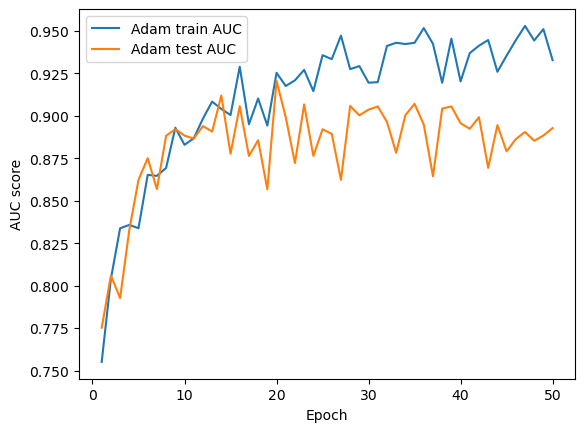

In [21]:
import copy
optimizers = {
    'Adam': Adam(model.parameters(), lr=lr, weight_decay=1e-4),
    # 'SGD': SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
}

best_models = {}
best_aucs = {}

for optimizer_name, optimizer in optimizers.items():
    print(f"Training with {optimizer_name} optimizer...")

    model.train()  # Reset the model to training mode

    best_auc = 0
    best_acc = 0
    best_epoch = 0

    train_auc_scores = []
    test_auc_scores = []
    epochs = []

    for epoch in range(NUM_EPOCHS):
        train_correct = 0
        train_total = 0
        train_loss = 0
        model.train()
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.float().to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        print(f"==> Evaluating after epoch {epoch + 1} ...")
        train_metrics = evaluate(train_loader)
        test_metrics = evaluate(test_loader)
        
        print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
        print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

        # Check if AUC score improved
        if test_metrics[0] > best_auc:
            best_auc = test_metrics[0]
            best_acc = test_metrics[1]
            best_epoch = epoch + 1
            print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
            best_models[optimizer_name] = {
                'state_dict': copy.deepcopy(model.state_dict()),
                'auc': best_auc,
                'acc': best_acc,
                'epoch': best_epoch
            }

        # Append AUC scores and epoch numbers
        train_auc_scores.append(train_metrics[0])
        test_auc_scores.append(test_metrics[0])
        epochs.append(epoch+1)

    best_aucs[optimizer_name] = best_auc

    # Plot the train and test AUC scores vs epoch for each optimizer
    plt.plot(epochs, train_auc_scores, label=f"{optimizer_name} train AUC")
    plt.plot(epochs, test_auc_scores, label=f"{optimizer_name} test AUC")

# Find the optimizer with the best AUC score
best_optimizer = max(best_aucs, key=best_aucs.get)
best_model_info = best_models[best_optimizer]

# Save the best model
torch.save(best_model_info['state_dict'], 'best_pretrained_model_nodulemnist3d.pth')

print(f"Best model: {best_optimizer}, AUC: {best_model_info['auc']:.4f}, ACC: {best_model_info['acc']:.4f}, epoch: {best_model_info['epoch']}")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()

# LibAUC

In [13]:
# Get the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

# List the files in the current directory
files = os.listdir(current_directory)
print("Files in the current directory:")
for file in files:
    print(file)

Current working directory: d:\Download\CSCE633\project
Files in the current directory:
AdrenalMNIST3D.ipynb
best_model_adrenalmnist3d.pth
best_model_breastmnist.pth
best_model_breastmnist_no_dropout.pth
best_model_chestmnist.pth
best_model_nodulemnist3d.pth
best_model_pneumoniamnist.pth
best_model_pneumoniamnist_no_dropout.pth
best_model_synapsemnist3d.pth
best_model_vesselmnist3d.pth
best_pretraind_model_breastmnist.pth
best_pretraind_model_pneumoniamnist.pth
best_pretrained_model_adrenalmnist3d.pth
best_pretrained_model_chestmnist.pth
best_pretrained_model_nodulemnist3d.pth
best_pretrained_model_pneumoniamnist.pth
best_pretrained_model_synapsemnist3d.pth
best_pretrained_model_vesselmnist3d.pth
BreastMNIST.ipynb
ChestMNIST.ipynb
CSE633-Spring23-Project-Description.pdf.pdf
data
get_started.ipynb
load_all_data.ipynb
NoduleMNIST3D.ipynb
PneumoniaMNIST.ipynb
resnet2p1d.py
SynapseMNIST3D.ipynb
VesselMNIST3D.ipynb
__pycache__


## Resnet18-3D

In [14]:
model.load_state_dict(torch.load("best_pretrained_model_nodulemnist3d.pth"))

<All keys matched successfully>

In [15]:
SEED = 123
BATCH_SIZE = 32 # change to small batch size (since found batch_size = 64 increase computational time) and increase epochs for better results
lr = 0.001 
epoch_decay = 0.003
weight_decay = 1e-5
margin = 1.0

In [16]:
# define loss & optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, 
                 loss_fn=loss_fn, 
                 lr=lr, 
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

100%|██████████| 37/37 [00:21<00:00,  1.73it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.906756566233111, Train ACC: 19.493955094991364
Test AUC: 0.8481787297951092, Test ACC: 20.193548387096776
==> Best test AUC and ACC score updated: 0.8482, 20.1935


100%|██████████| 37/37 [00:17<00:00,  2.13it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.8658680637098829, Train ACC: 20.16580310880829
Test AUC: 0.8293678958334132, Test ACC: 21.12258064516129


100%|██████████| 37/37 [00:19<00:00,  1.92it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.9088916469791657, Train ACC: 20.265975820379964
Test AUC: 0.8743155052961089, Test ACC: 20.548387096774192
==> Best test AUC and ACC score updated: 0.8743, 20.5484


100%|██████████| 37/37 [00:18<00:00,  2.05it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.8641485351183132, Train ACC: 20.27461139896373
Test AUC: 0.8526314494094667, Test ACC: 20.787096774193547


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.8993170259606095, Train ACC: 20.559585492227978
Test AUC: 0.8713153377593033, Test ACC: 21.322580645161292


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.8917913800079134, Train ACC: 20.283246977547496
Test AUC: 0.8645568384361487, Test ACC: 20.348387096774193


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.9047611958179592, Train ACC: 20.50949913644214
Test AUC: 0.8683644309075345, Test ACC: 20.825806451612902


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.9100560932905437, Train ACC: 19.936096718480137
Test AUC: 0.8860588692916279, Test ACC: 20.761290322580646
==> Best test AUC and ACC score updated: 0.8861, 20.7613


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.9169348779102785, Train ACC: 20.526770293609673
Test AUC: 0.9047584152756567, Test ACC: 19.858064516129033
==> Best test AUC and ACC score updated: 0.9048, 19.8581


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.9117954859062433, Train ACC: 19.92573402417962
Test AUC: 0.9178172306620583, Test ACC: 19.870967741935484
==> Best test AUC and ACC score updated: 0.9178, 19.8710


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.9177038127910556, Train ACC: 19.443868739205527
Test AUC: 0.8851828778660675, Test ACC: 19.509677419354837


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.921865917823564, Train ACC: 19.96027633851468
Test AUC: 0.8984364067445962, Test ACC: 19.53548387096774


100%|██████████| 37/37 [00:15<00:00,  2.31it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.9287180800983273, Train ACC: 19.053540587219345
Test AUC: 0.905209784229181, Test ACC: 19.638709677419357


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.927926722904189, Train ACC: 19.16580310880829
Test AUC: 0.9093275988857886, Test ACC: 18.70967741935484


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.9294930675179529, Train ACC: 18.587219343696027
Test AUC: 0.9111644776838743, Test ACC: 18.651612903225807


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.9263873707080229, Train ACC: 18.207253886010363
Test AUC: 0.9107155978599945, Test ACC: 18.44516129032258


100%|██████████| 37/37 [00:17<00:00,  2.13it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.9306978173947241, Train ACC: 18.407599309153714
Test AUC: 0.8901657888726854, Test ACC: 17.858064516129033


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.9194255995239878, Train ACC: 18.088082901554404
Test AUC: 0.8905185028891927, Test ACC: 18.025806451612905


100%|██████████| 37/37 [00:17<00:00,  2.13it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.9280957685366926, Train ACC: 17.746113989637305
Test AUC: 0.8969291304959407, Test ACC: 17.225806451612904


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.9269741512847919, Train ACC: 18.6580310880829
Test AUC: 0.9024045618334411, Test ACC: 17.941935483870967


100%|██████████| 37/37 [00:17<00:00,  2.13it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.9169773738523741, Train ACC: 18.62348877374784
Test AUC: 0.91267814560918, Test ACC: 19.225806451612904


100%|██████████| 37/37 [00:17<00:00,  2.11it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.9287526413636014, Train ACC: 17.78929188255613
Test AUC: 0.9123103488944005, Test ACC: 17.419354838709676


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.9278771328327966, Train ACC: 17.917098445595855
Test AUC: 0.9040631837830115, Test ACC: 16.393548387096775


100%|██████████| 37/37 [00:17<00:00,  2.12it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.9335437643845573, Train ACC: 17.64594127806563
Test AUC: 0.8856559891258167, Test ACC: 17.025806451612905


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.9340319562513181, Train ACC: 17.518134715025905
Test AUC: 0.8964617311169036, Test ACC: 16.670967741935485


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.9335150193974563, Train ACC: 17.998272884283246
Test AUC: 0.916348729495281, Test ACC: 17.6


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.9297993599847818, Train ACC: 17.45250431778929
Test AUC: 0.923990031360721, Test ACC: 17.148387096774194
==> Best test AUC and ACC score updated: 0.9240, 17.1484


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.9270641232225898, Train ACC: 17.4006908462867
Test AUC: 0.9099465907655564, Test ACC: 17.54193548387097


100%|██████████| 37/37 [00:16<00:00,  2.19it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.932113979450936, Train ACC: 17.65112262521589
Test AUC: 0.9152922396887915, Test ACC: 16.52258064516129


100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.9225729021924675, Train ACC: 18.620034542314336
Test AUC: 0.9047218889029234, Test ACC: 18.29032258064516


100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.917063846850073, Train ACC: 17.464594127806564
Test AUC: 0.8973271117452152, Test ACC: 17.193548387096776


100%|██████████| 37/37 [00:17<00:00,  2.12it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.9340951803137159, Train ACC: 17.238341968911918
Test AUC: 0.8865206309495102, Test ACC: 17.045161290322582


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.9296063382092247, Train ACC: 17.278065630397236
Test AUC: 0.894363879654828, Test ACC: 17.06451612903226


100%|██████████| 37/37 [00:17<00:00,  2.11it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.9260926956962108, Train ACC: 17.02763385146805
Test AUC: 0.9002646722689827, Test ACC: 16.6


100%|██████████| 37/37 [00:17<00:00,  2.16it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.9230074964768802, Train ACC: 17.459412780656304
Test AUC: 0.9057072118494534, Test ACC: 17.296774193548387


100%|██████████| 37/37 [00:17<00:00,  2.16it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.9262014951302707, Train ACC: 16.763385146804836
Test AUC: 0.8991682949872605, Test ACC: 16.55483870967742


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.9303051065021888, Train ACC: 17.673575129533678
Test AUC: 0.9102366012818599, Test ACC: 16.43225806451613


100%|██████████| 37/37 [00:18<00:00,  1.97it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.9126956312854483, Train ACC: 17.214162348877373
Test AUC: 0.9178994632442908, Test ACC: 16.451612903225808


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.9232087648778152, Train ACC: 17.02763385146805
Test AUC: 0.9219276034469999, Test ACC: 16.219354838709677


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.9427423987478336, Train ACC: 17.13816925734024
Test AUC: 0.9089730930786966, Test ACC: 16.470967741935485


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.9232090835680653, Train ACC: 17.350604490500864
Test AUC: 0.8968608303414337, Test ACC: 16.561290322580646


100%|██████████| 37/37 [00:17<00:00,  2.12it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.9277527730365893, Train ACC: 16.986183074265977
Test AUC: 0.9013526926457962, Test ACC: 16.06451612903226


100%|██████████| 37/37 [00:17<00:00,  2.12it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.9385504616211138, Train ACC: 17.730569948186528
Test AUC: 0.9000277560083594, Test ACC: 17.606451612903225


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.9333633615098147, Train ACC: 16.471502590673577
Test AUC: 0.9229134925578892, Test ACC: 17.767741935483873


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.9330857453018248, Train ACC: 16.929188255613127
Test AUC: 0.9161589703400048, Test ACC: 15.838709677419354


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.941891038684517, Train ACC: 17.528497409326423
Test AUC: 0.8937123277425002, Test ACC: 17.46451612903226


100%|██████████| 37/37 [00:17<00:00,  2.13it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.9352816740351757, Train ACC: 17.22452504317789
Test AUC: 0.9018155595203009, Test ACC: 17.09032258064516


100%|██████████| 37/37 [00:17<00:00,  2.13it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.9452420180187731, Train ACC: 16.887737478411054
Test AUC: 0.886789782694955, Test ACC: 16.36774193548387


100%|██████████| 37/37 [00:17<00:00,  2.16it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.9189687789902321, Train ACC: 17.179620034542314
Test AUC: 0.9032737848039571, Test ACC: 17.81935483870968


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.9303235383040874, Train ACC: 16.46113989637306
Test AUC: 0.9149921279231623, Test ACC: 17.44516129032258
Best test AUC: 0.9240 and ACC: 17.1484 achieved at epoch 27


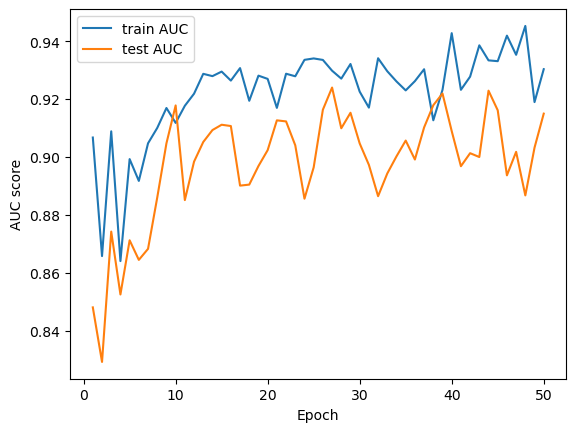

In [17]:
# training and testing
best_auc = 0
best_acc = 0
best_epoch = 0
patience = NUM_EPOCHS
stop_counter = 0

train_auc_scores = []
test_auc_scores = []
epochs = []

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    train_loss = 0
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.float().to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        targets = targets.squeeze().long()
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    print(f"==> Evaluating after epoch {epoch + 1} ...")
    train_metrics = evaluate(train_loader)
    test_metrics = evaluate(test_loader)

    print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
    print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

    # Check if AUC score improved
    if test_metrics[0] > best_auc:
        best_auc = test_metrics[0]
        best_acc = test_metrics[1]
        best_epoch = epoch + 1
        print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
        # Save the model state
        torch.save(model.state_dict(), 'best_model_nodulemnist3d.pth')
    #     stop_counter = 0
    # else:
    #     stop_counter += 1

    # Append AUC scores and epoch numbers
    train_auc_scores.append(train_metrics[0])
    test_auc_scores.append(test_metrics[0])
    epochs.append(epoch+1)

    # Check for early stopping
    # if stop_counter >= patience:
    #     print("Early stopping triggered")
    #     break

print(f"Best test AUC: {best_auc:.4f} and ACC: {best_acc:.4f} achieved at epoch {best_epoch}")

# Plot the train and test AUC scores vs epoch
plt.plot(epochs, train_auc_scores, label='train AUC')
plt.plot(epochs, test_auc_scores, label='test AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()